#### <h1><center>CSE 676-B: Deep Learning</center></h1>
### <center>Prof. Alina Vereshchaka</center>
### <center>Spring 2024</center>

<center>
<h2>Autoencoder and Transformer Architectures</h2>
<h3>Team:

Charvi Kusuma, charviku@buffalo.edu

Tarun Reddi, bhanucha@buffalo.edu</h3>
<h1 style="color: blue">Assignment 2</h1>
<span style="color: red">

Checkpoint: April 2, Tue, 11:59 pm

Due date: April 11, Thu 11:59pm

</span>
<center>


# Bonus points [max 10 points]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from keras.preprocessing.image import load_img, img_to_array


from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Dense, Embedding
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


In [3]:
!unzip '/content/drive/MyDrive/DL/cnn_dataset.zip' -d '/content/cnn_dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/cnn_dataset/vehicles/5499.jpg  
  inflating: /content/cnn_dataset/vehicles/55.jpg  
  inflating: /content/cnn_dataset/vehicles/550.jpg  
  inflating: /content/cnn_dataset/vehicles/5500.jpg  
  inflating: /content/cnn_dataset/vehicles/5501.jpg  
  inflating: /content/cnn_dataset/vehicles/5502.jpg  
  inflating: /content/cnn_dataset/vehicles/5503.jpg  
  inflating: /content/cnn_dataset/vehicles/5504.jpg  
  inflating: /content/cnn_dataset/vehicles/5505.jpg  
  inflating: /content/cnn_dataset/vehicles/5506.jpg  
  inflating: /content/cnn_dataset/vehicles/5507.jpg  
  inflating: /content/cnn_dataset/vehicles/5508.jpg  
  inflating: /content/cnn_dataset/vehicles/5509.jpg  
  inflating: /content/cnn_dataset/vehicles/551.jpg  
  inflating: /content/cnn_dataset/vehicles/5510.jpg  
  inflating: /content/cnn_dataset/vehicles/5511.jpg  
  inflating: /content/cnn_dataset/vehicles/5512.jpg  
  inflating: /content/cnn_dataset/v

In [4]:
import os

In [5]:
mydata = "/content/cnn_dataset"
categories = os.listdir(mydata)
data = []
labels = []
image_shapes = []
means = []
stds = []

In [6]:
for c in categories:
    cp = os.path.join(mydata, c)
    image_files = os.listdir(cp)
    for img_file in image_files:
        img_path = os.path.join(cp, img_file)
        img = load_img(img_path, target_size=(64, 64))
        img_arr = img_to_array(img)
        data.append(img_arr)
        labels.append(c)
        image_shapes.append(img_arr.shape)
        means.append(np.mean(img_arr))
        stds.append(np.std(img_arr))

In [7]:
data = np.array(data)
labels = np.array(labels)
image_shapes = np.array(image_shapes)
mean_pixel_values = np.array(means)
std_dev_pixel_values = np.array(stds)

In [8]:
print("Dataset statistics:")
print("Number of examples:", len(data))
print("Number of categories:", len(categories))
print("Image shape:", image_shapes[0])
print("Mean pixel value (mean):", np.mean(mean_pixel_values))
print("Mean pixel value (standard deviation):", np.std(mean_pixel_values))
print("Standard deviation of pixel values (mean):", np.mean(std_dev_pixel_values))
print("Standard deviation of pixel values (standard deviation):", np.std(std_dev_pixel_values))


Dataset statistics:
Number of examples: 30000
Number of categories: 3
Image shape: [64 64  3]
Mean pixel value (mean): 113.808624
Mean pixel value (standard deviation): 26.474377
Standard deviation of pixel values (mean): 64.29669
Standard deviation of pixel values (standard deviation): 11.807852


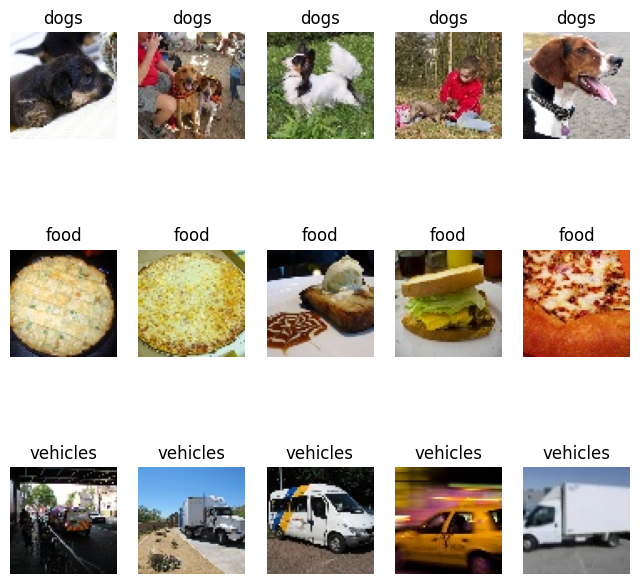

In [9]:
u = np.unique(labels)
num_samples = 5
plt.figure(figsize=(8, 8))
for i, label in enumerate(u):
    samples = data[labels == label][:num_samples]
    for j, sample in enumerate(samples):
        plt.subplot(len(u), num_samples, i * num_samples+j + 1)
        plt.imshow(sample.astype('uint8'))
        plt.title(label)
        plt.axis('off')
plt.show()

In [10]:
label_idx = {label: idx for idx, label in enumerate(u)}
labels = np.array([label_idx[label] for label in labels])
labels = to_categorical(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (18000, 64, 64, 3)
y_train shape: (18000, 3)
X_test shape: (6000, 64, 64, 3)
y_test shape: (6000, 3)
X_val shape: (6000, 64, 64, 3)
y_val shape: (6000, 3)


## Vision Transformer (ViT) for Image Classification [7 points]

In [13]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def build(self, input_shape):
        self.projection = Dense(units=self.projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [14]:
def create_vit_classifier():
    input_shape = (64, 64, 3)
    num_classes = len(categories)
    inputs = Input(shape=input_shape)
    rescaled_inputs = Rescaling(scale=1./255)(inputs)

    patch_size = 8
    num_patches = (64 // patch_size) ** 2
    patch_dim = 3 * patch_size ** 2

    patches = Patches(patch_size)(rescaled_inputs)
    encoded_patches = PatchEncoder(num_patches, patch_dim)(patches)

    for _ in range(4):  # Let's create 4 layers of Transformer encoders
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=patch_dim, dropout=0.1
        )(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = Dense(units=2048, activation='relu')(x3)
        x3 = Dense(units=patch_dim)(x3)
        encoded_patches = Add()([x3, x2])

    representation = Flatten()(encoded_patches)
    representation = Dense(units=2048, activation='relu')(representation)
    representation = Dropout(0.5)(representation)
    outputs = Dense(units=num_classes, activation='softmax')(representation)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [15]:
vit_classifier = create_vit_classifier()

In [16]:
vit_classifier.compile(optimizer=Adam(),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [18]:
history = vit_classifier.fit(X_train, y_train,
                             batch_size=32,
                             epochs=20,
                             validation_data=(X_val, y_val),
                             callbacks=[ModelCheckpoint('vit_classifier.h5', save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Epoch 1/20
563/563 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.7233

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


563/563 [==============================] - 37s 65ms/step - loss: 0.6776 - accuracy: 0.7233 - val_loss: 0.5063 - val_accuracy: 0.8070
Epoch 2/20
563/563 [==============================] - 31s 55ms/step - loss: 0.5390 - accuracy: 0.7899 - val_loss: 0.5795 - val_accuracy: 0.7523
Epoch 3/20
563/563 [==============================] - 31s 56ms/step - loss: 0.6355 - accuracy: 0.7429 - val_loss: 0.6891 - val_accuracy: 0.7167
Epoch 4/20
563/563 [==============================] - 32s 57ms/step - loss: 0.7313 - accuracy: 0.6994 - val_loss: 0.7266 - val_accuracy: 0.6703
Epoch 5/20
563/563 [==============================] - 29s 52ms/step - loss: 0.7431 - accuracy: 0.6899 - val_loss: 0.7911 - val_accuracy: 0.6253
Epoch 6/20
563/563 [==============================] - 31s 55ms/step - loss: 0.9776 - accuracy: 0.5196 - val_loss: 0.9741 - val_accuracy: 0.5063


In [19]:
test_results = vit_classifier.evaluate(X_test, y_test, batch_size=32)
print(f"Test accuracy: {test_results[1]*100:.2f}%")

188/188 [==============================] - 3s 17ms/step - loss: 0.4969 - accuracy: 0.8115
Test accuracy: 81.15%


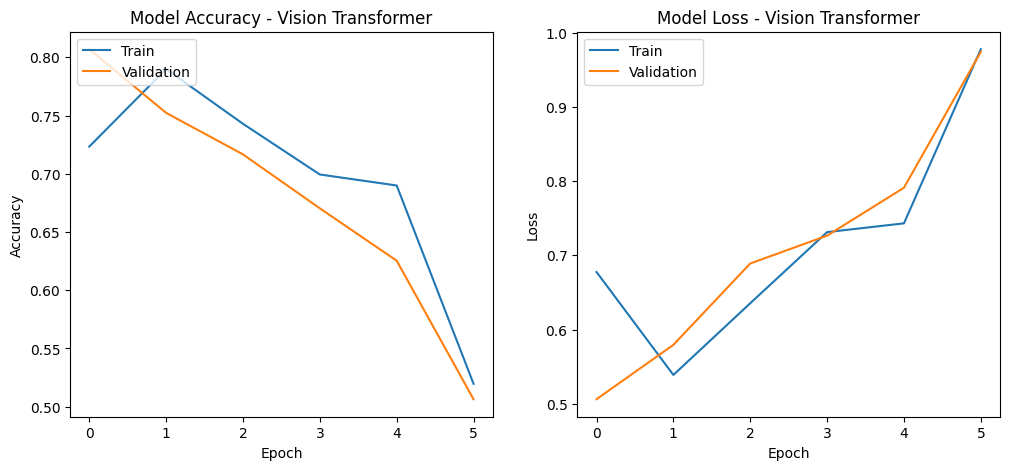

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy - Vision Transformer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Vision Transformer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


188/188 [==============================] - 3s 15ms/step


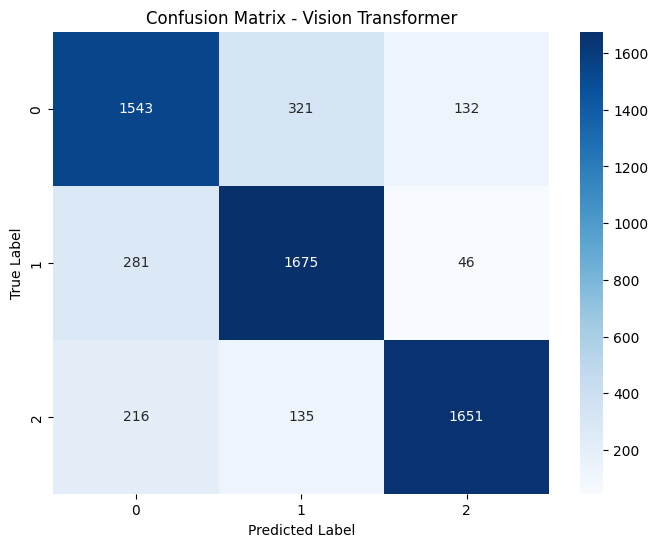

In [21]:
y_pred = vit_classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Vision Transformer')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [22]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.8151
Recall: 0.8115
F1 Score: 0.8124


## EfficientNet [3 points]

In [23]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input

In [24]:
base_model = EfficientNetB0(input_shape=(64, 64, 3),
                            include_top=False,
                            weights=None)

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

In [26]:
model = Model(inputs=base_model.input, outputs=predictions)


In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[ModelCheckpoint('efficientnet_model.h5', save_best_only=True),
                               EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/10
563/563 [==============================] - ETA: 0s - loss: 1.0050 - accuracy: 0.5132

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


563/563 [==============================] - 76s 65ms/step - loss: 1.0050 - accuracy: 0.5132 - val_loss: 1.0298 - val_accuracy: 0.4660
Epoch 2/10
563/563 [==============================] - 33s 58ms/step - loss: 0.7967 - accuracy: 0.6523 - val_loss: 0.7552 - val_accuracy: 0.7075
Epoch 3/10
563/563 [==============================] - 32s 57ms/step - loss: 0.6592 - accuracy: 0.7296 - val_loss: 0.6174 - val_accuracy: 0.7622
Epoch 4/10
563/563 [==============================] - 32s 56ms/step - loss: 0.5736 - accuracy: 0.7658 - val_loss: 0.5636 - val_accuracy: 0.7863
Epoch 5/10
563/563 [==============================] - 32s 57ms/step - loss: 0.5151 - accuracy: 0.7942 - val_loss: 0.5209 - val_accuracy: 0.8028
Epoch 6/10
563/563 [==============================] - 32s 57ms/step - loss: 0.4692 - accuracy: 0.8143 - val_loss: 0.4659 - val_accuracy: 0.8210
Epoch 7/10
563/563 [==============================] - 31s 54ms/step - loss: 0.4266 - accuracy: 0.8316 - val_loss: 0.4910 - val_accuracy: 0.8082
Epo

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')

188/188 [==============================] - 2s 10ms/step - loss: 0.4692 - accuracy: 0.8308
Test accuracy: 0.8308, Test loss: 0.4692


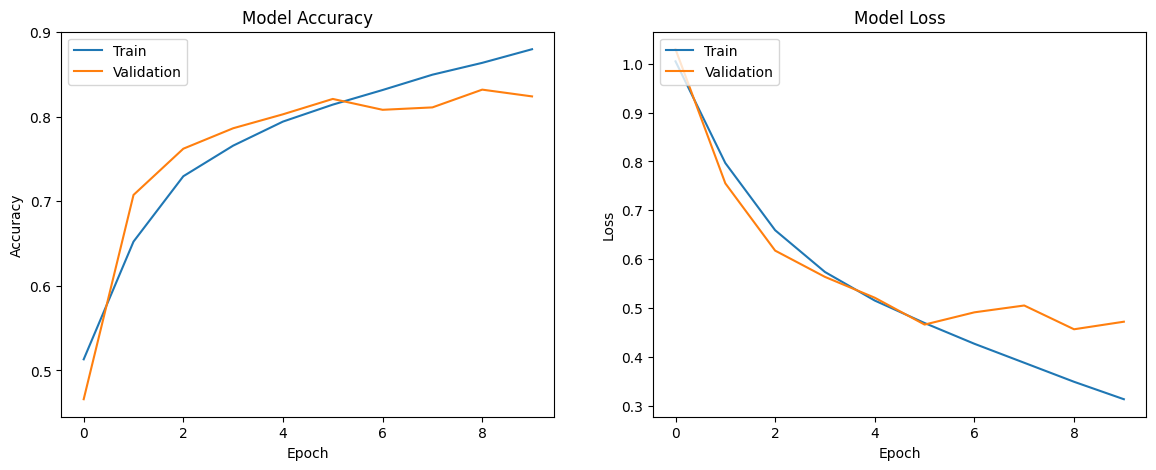

In [30]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

188/188 [==============================] - 3s 11ms/step


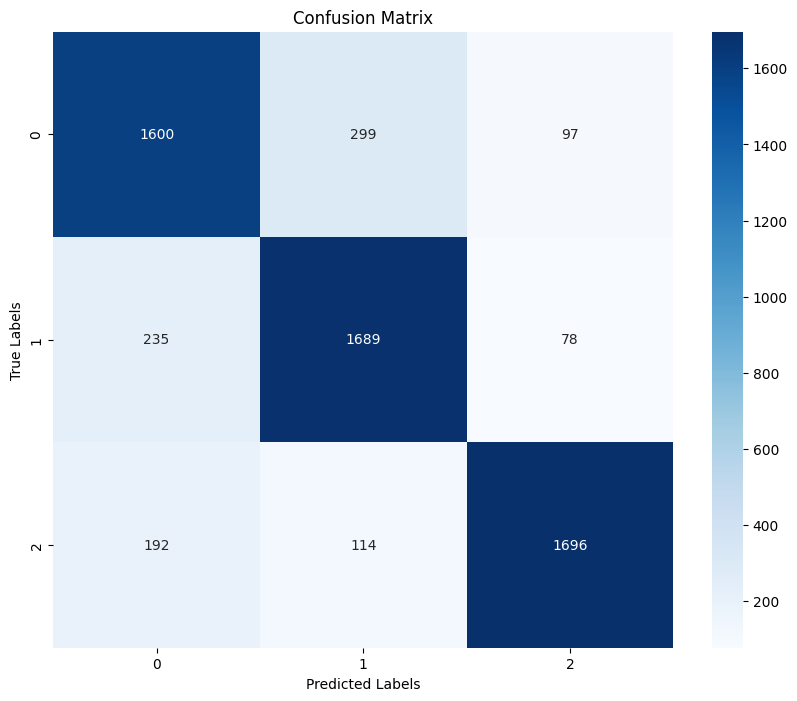

In [31]:
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [32]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.8332
Recall: 0.8308
F1 Score: 0.8315
